# Multi-task model using scaled RNA-seq profiles 
- Authors: Doris Fu, Eshika Saxena
- Objective: base line multi-task model to perform direct prediction of cell viability score from cell line RNA-seq profile (expression values of each gene scaled across samples)

## Load libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import os 
import shutil

import copy

import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
import CCLE_utils
import MMRF_utils
from sklearn import preprocessing


## Load cell line data

In [2]:
crispr_rnaseq_merged = pd.read_csv('rnaseq_crispr_merged.csv')
crispr_rnaseq_merged = crispr_rnaseq_merged.drop(columns = ['DepMap_ID'])

In [3]:
map_dict = CCLE_utils.get_map_dict('Ensembl_HGNC_map_042421.csv')

In [4]:
response_cols = [col for col in crispr_rnaseq_merged.columns if '_y' in col]
crispr = crispr_rnaseq_merged[response_cols]
rnaseq = crispr_rnaseq_merged.drop(response_cols, axis=1)
rnaseq = CCLE_utils.hgnc_to_ensembl(rnaseq, map_dict)


In [5]:
#scale each column to range 0-1

min_max_scaler = preprocessing.MinMaxScaler()
rnaseq_scaled = min_max_scaler.fit_transform(rnaseq.values)
rnaseq_scaled = pd.DataFrame(rnaseq_scaled)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(rnaseq_scaled,crispr,random_state=42, train_size=0.7)

# Train NN model on cell line

In [24]:
def generate_model(N_in, N_out):
    # N_in : number of input feature, N_out : number of heads, shapes = size of dense layer 1

    inputs = K.layers.Input(shape = (N_in,))
    x = K.layers.Dropout(0.2, input_shape=(N_in,))(inputs)
    x = K.layers.Dense(1024, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001))(x)
    x = K.layers.Dropout(0.5)(x)
    x = K.layers.Dense(128, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001))(x)
    x = K.layers.Dropout(0.5)(x)
    x = K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.001))(x)
    y1 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y1')(x)
    y2 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y2')(x)
    y3 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y3')(x)
    y4 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y4')(x)
    y5 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y5')(x)
    y6 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y6')(x)
    y7 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y7')(x)
    y8 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y8')(x)
    y9 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y9')(x)
    y10 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y10')(x)
    y11 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y11')(x)
    y12 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y12')(x)
    y13 = K.layers.Dense(1, kernel_regularizer=K.regularizers.l2(l=0.001), name='y13')(x)

    model = K.models.Model(inputs = inputs, outputs = [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13])
    model.compile(optimizer='adam',
                  loss=generate_loss(N_out, 'mse'))
    
    return model

In [19]:
def generate_loss(N_out, loss):
    L = dict()
    for i in range(1, N_out+1):
        k = 'y'+str(i)
        L[k] = loss
    return L

## Feed scaled RNA directly to model  


In [26]:
model = generate_model(X_train.shape[1], 13)
model.summary()

print("Input", model.input_shape, "Output", model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 18914)]      0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 18914)        0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         19368960    dropout_3[0][0]                  
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 1024)         0           dense_3[0][0]                    
____________________________________________________________________________________________

In [27]:
history = model.fit(X_train,y_train,epochs=500, validation_data=(X_test, y_test),verbose=0)

# Eval performance on cell line test set

In [28]:
def plot_loss(perf_dict):
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    loss = perf_dict['loss']
    val_loss = perf_dict['val_loss']
    ax1.plot(loss)
    ax2.plot(val_loss)
    ax1.set_xlabel('epochs')
    ax2.set_xlabel('epochs')

    ax1.set_ylabel('loss')
    ax2.set_ylabel('val_loss')
    plt.show()

In [1]:
def plot_pred(y_train, y_train_pred, y_test, y_test_pred, i):
    # i: index of gene
    fig, ax = plt.subplots(1,1)

    ax.scatter(y_train[:,i],y_train_pred[i,:,0], label='Train', color='#4287f5')
    ax.scatter(y_test[:,i],y_test_pred[i,:,0], label='Test', color='#f2797f')

    ax.set_xlabel('True Response')
    ax.set_ylabel('Predicted Response')
    ax.legend()
    ax.set_title('CRISPR Knockout Experiment '+str(i))

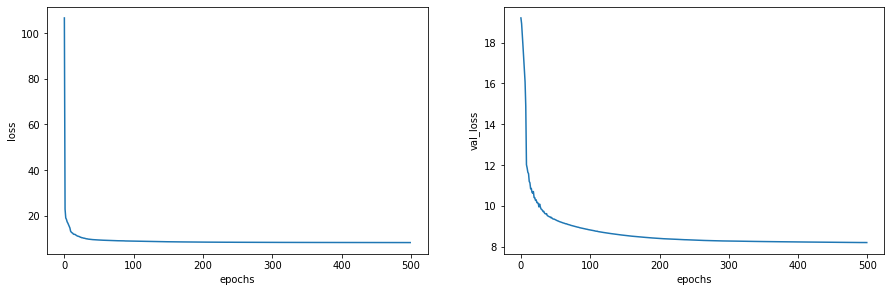

In [29]:
plot_loss(history.history)

In [30]:
y_train_pred = np.array(model.predict(X_train))
y_test_pred = np.array(model.predict(X_test))

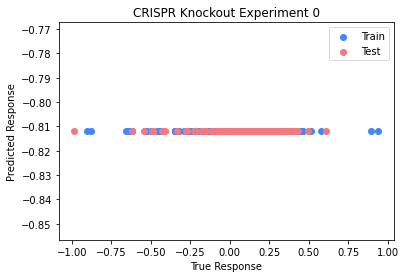

In [58]:
plot_pred(np.array(y_train), y_train_pred, np.array(y_test), y_test_pred, 0)

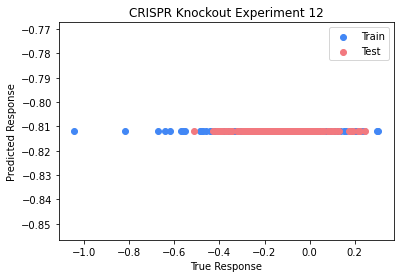

In [60]:
plot_pred(np.array(y_train), y_train_pred, np.array(y_test), y_test_pred, 12)